In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os, sys, random, json, re
from pprint import pprint
from tqdm import tqdm
from collections import Counter, defaultdict
from typing import List, Union
from PIL import Image
np.set_printoptions(precision=4)
sys.path.append("../scripts/diffuser/")
from utils import *
import textwrap

In [2]:
import matplotlib
def heatmap(data, 
            y_label, x_label, 
            row_labels, col_labels, 
            x_ticks=None, y_ticks=None, 
            ax=None,
            cbar_kw=None, 
            cbarlabel="", 
            **kwargs
    ):

    if ax is None: ax = plt.gca()
    if cbar_kw is None: cbar_kw = {}
    im = ax.imshow(data, aspect="auto", **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    if x_ticks is None: x_ticks = np.arange(data.shape[1])
    if y_ticks is None: y_ticks = np.arange(data.shape[0])
    
    ax.set_xticks(x_ticks, labels=col_labels)
    ax.set_yticks(y_ticks, labels=row_labels)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
def get_em_cm_and_confusion_matrices(
    ckpt_handle: str,
    epochs_for_eval: List[int],
    error_metric: str, # ['mse', 'l1']
    image_size: int=32,
):
    global COLORS
    colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
    color2id = {k:i for i, k in enumerate(COLORS.keys())}

    error_metric = eval("mse")
    count = 0
    cm = 0
    em = 0
    
    cfsmtrx_em_coarse = np.zeros((len(COLORS), len(COLORS)))
    cfsmtrx_cm_coarse = np.zeros((len(COLORS), len(COLORS)))

    cfsmtrx_em_fine = np.zeros((len(COLORS)*2, len(COLORS)))
    cfsmtrx_cm_fine = np.zeros((len(COLORS)*2, len(COLORS)))

    for infr_handle in os.listdir(f"../scripts/diffuser/output/{ckpt_handle}/infr/{split}_sentences/"):
        samples_dir = f"../scripts/diffuser/output/{ckpt_handle}/infr/{split}_sentences/{infr_handle}/samples"
        
        epoch_for_eval = int(re.findall(r'epoch(\d+)', infr_handle)[0])
        if not epoch_for_eval in epochs_for_eval: continue
        
        for f in tqdm(os.listdir(samples_dir)):
            if ".png" in f:
                with open(os.path.join(samples_dir, f.replace(".png", ".txt")), "r") as txt:
                    input_texts = [l.strip() for l in txt.readlines()]
                im = Image.open(os.path.join(samples_dir, f))
                im_array = np.array(im, dtype=np.float64) / 255
                h, w, d = tuple(im_array.shape)
                bs = int(h // image_size)
                pixels = np.reshape(im_array, (bs, h//bs, w, d))
                pixels = np.reshape(pixels, (bs, -1, d))
                
                for i, m in enumerate(pixels):
                    sentence = input_texts[i]
                    color_pair = tuple([w for w in sentence.strip().replace(".", "").split() if w in COLORS])
                    if "bottom" in sentence: color_pair = color_pair[::-1]
                    gth_top_color, gth_bottom_color = color_pair

                    kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0).fit(m)
                    labels = kmeans.predict(m)
                    image_size = np.sqrt(labels.shape[0])
                    
                    x_coords, y_coords = defaultdict(list), defaultdict(list)
                    for i, l in enumerate(labels):
                        x_coords[l].append(i%image_size)
                        y_coords[l].append(image_size - i//image_size - 1)
                    cluster_centers = {
                        l: (np.mean(x_coords[l]), np.mean(y_coords[l]))
                        for l in labels
                    }
                    cluster_centers = dict(sorted([(k, v) for k, v in cluster_centers.items()], key=lambda x: x[1][1]))
                    bottom_cluster_id, background_cluster_id, top_cluster_id = list(cluster_centers.keys())
                    postproc = kmeans.cluster_centers_
                    
                    
                    error = error_metric([postproc[top_cluster_id]], colors_array)
                    top_color = list(COLORS.keys())[error.argmin()]
                    error = error_metric([postproc[bottom_cluster_id]], colors_array)
                    bottom_color = list(COLORS.keys())[error.argmin()]

                    count += 1
                    if gth_top_color == top_color and gth_bottom_color == bottom_color: 
                        em += 1
                        cm += 1
                        continue
                    cfsmtrx_em_coarse[color2id[gth_bottom_color]][color2id[gth_top_color]] += 1
                    cfsmtrx_em_fine[
                        color2id[gth_bottom_color]*2 + int("bottom" in sentence)\
                            ][color2id[gth_top_color]] += 1
                    if gth_top_color == bottom_color and gth_bottom_color == top_color:
                        cm += 1 
                        continue
                    cfsmtrx_cm_coarse[color2id[gth_bottom_color]][color2id[gth_top_color]] += 1
                    cfsmtrx_cm_fine[
                        color2id[gth_bottom_color]*2 + int("bottom" in sentence)\
                            ][color2id[gth_top_color]] += 1
    return (
        em, cm, count,
        cfsmtrx_em_coarse,
        cfsmtrx_cm_coarse,
        cfsmtrx_em_fine,
        cfsmtrx_cm_fine,
    )

### Evaluate & Visualize samples generated during training

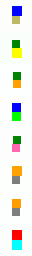

In [2]:
handle = "1105_154436"
epoch = 49
samples_dir = f"../scripts/diffuser/output/{handle}/samples"
for f in os.listdir(samples_dir):
    if ".png" in f and f"{epoch}_" in f:
        break
with open(os.path.join(samples_dir, f.replace(".png", ".txt")), "r") as txt:
    input_texts = [l.strip() for l in txt.readlines()]
im = Image.open(os.path.join(samples_dir, f))
im

In [6]:
K = 2
bs = 8
im_array = np.array(im, dtype=np.float64) / 255
print(im_array.shape)
h, w, d = tuple(im_array.shape)
assert d == 3
pixels = np.reshape(im_array, (bs, h//bs, w, d))
pixels = np.reshape(pixels, (bs, -1, d))
print(pixels.shape)

(256, 32, 3)
(8, 1024, 3)


In [2]:
def visualize_single_sq(pixels, input_texts, COLORS, error_metric):
    colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
    bs = pixels.shape[0]
    fig = plt.figure(figsize=(9, 3*bs))

    for i, m in enumerate(pixels):
        ax = fig.add_subplot(bs, 3, 3*i+1)
        ax.imshow(np.reshape(m, (-1, w, d)))
        ax.set_axis_off()
        ax.title.set_text(textwrap.fill(input_texts[i], 30))
        kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(m)
        labels = kmeans.predict(m)

        ax = fig.add_subplot(bs, 3, 3*i+2)
        background_cluster_id = int(sum([labels[0], labels[-1], labels[w-1], labels[-w]]) > 2)
        foreground_cluster_id = 1-background_cluster_id
        postproc = kmeans.cluster_centers_
        ax.imshow(postproc[labels].reshape(-1, w, d))
        ax.set_axis_off()
        
        error = error_metric([postproc[foreground_cluster_id]], colors_array)

        foreground_color = list(COLORS.keys())[error.argmin()]
        ax.title.set_text(f"foreground_color = {foreground_color}")

        ax = fig.add_subplot(bs, 3, 3*i+3)
        ax.bar(COLORS.keys(), 1-error, color=list(COLORS.keys()))
        ax.set_axis_off()
    plt.show()

In [3]:
def visualize_2sq(pixels, input_texts, COLORS, error_metric):
    colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
    bs = pixels.shape[0]
    fig = plt.figure(figsize=(6, 3*bs))

    for i, m in enumerate(pixels):
        ax = fig.add_subplot(bs, 2, 2*i+1)
        ax.imshow(np.reshape(m, (-1, w, d)))
        ax.set_axis_off()
        ax.title.set_text(textwrap.fill(input_texts[i], 30))

        ax = fig.add_subplot(bs, 2, 2*i+2)
        kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0).fit(m)
        labels = kmeans.predict(m)
        image_size = np.sqrt(labels.shape[0])
        
        x_coords, y_coords = defaultdict(list), defaultdict(list)
        for i, l in enumerate(labels):
            x_coords[l].append(i%image_size)
            y_coords[l].append(image_size - i//image_size - 1)
        cluster_centers = {
            l: (np.mean(x_coords[l]), np.mean(y_coords[l]))
            for l in labels
        }
        cluster_centers = dict(sorted([(k, v) for k, v in cluster_centers.items()], key=lambda x: x[1][1]))
        bottom_cluster_id, background_cluster_id, top_cluster_id = list(cluster_centers.keys())

        postproc = kmeans.cluster_centers_
        ax.imshow(postproc[labels].reshape(-1, w, d))
        ax.set_axis_off()
        
        error = error_metric([postproc[top_cluster_id]], colors_array)
        top_color = list(COLORS.keys())[error.argmin()]
        error = error_metric([postproc[bottom_cluster_id]], colors_array)
        bottom_color = list(COLORS.keys())[error.argmin()]
        ax.title.set_text(f"top_color = {top_color}\nbottom_color = {bottom_color}")

        #ax = fig.add_subplot(bs, 3, 3*i+3)
        #ax.bar(COLORS.keys(), 1-error, color=list(COLORS.keys()))
        #ax.set_axis_off()
    plt.show()

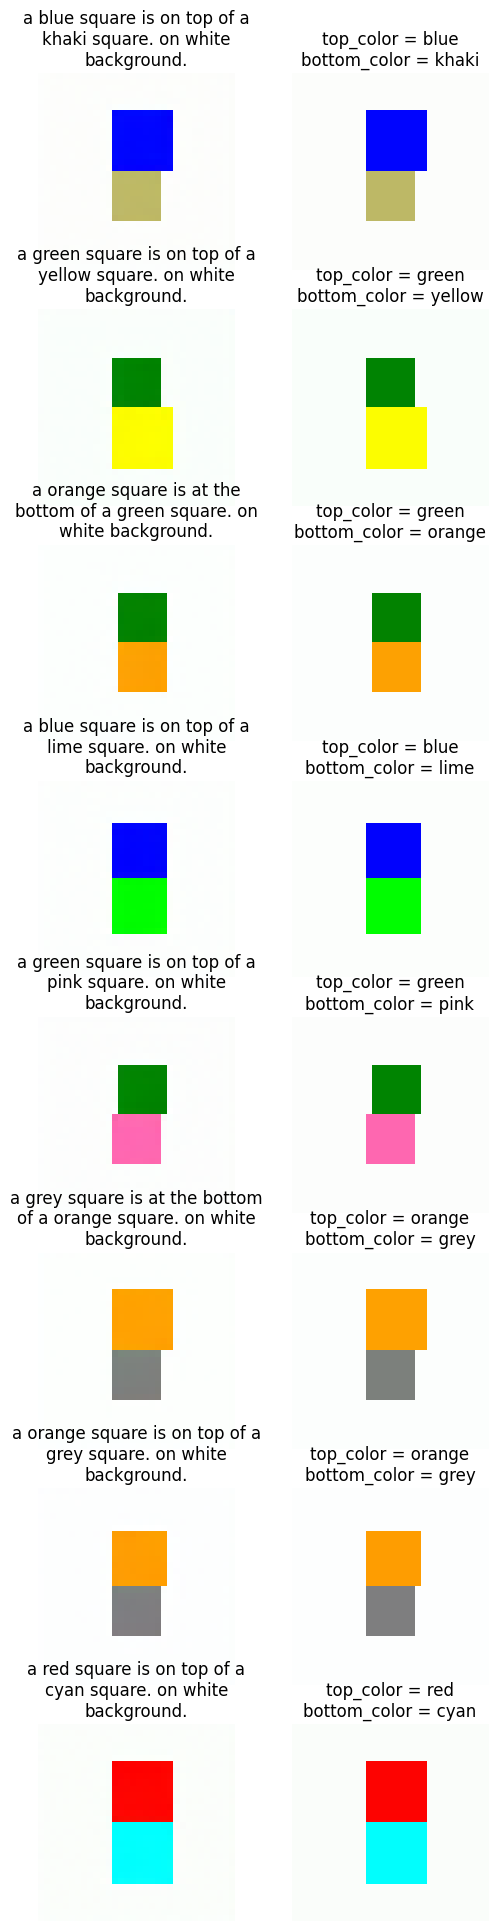

In [9]:
visualize_2sq(pixels, COLORS, error_metric=mse)


In [7]:
colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
K = 2
bs = 8
epoch_interval = [100, 115]
samples_dir = f"../scripts/diffuser/output/{handle}/samples"
color2id = {k:i for i, k in enumerate(COLORS.keys())}
count = 0
em = 0
confusion_matrix = np.zeros((len(COLORS), len(COLORS)))
for f in tqdm(os.listdir(samples_dir)):
    e = int(f.split("_")[0])
    if ".png" in f and e in range(*epoch_interval):
        with open(os.path.join(samples_dir, f.replace(".png", ".txt")), "r") as txt:
            input_texts = [l.strip() for l in txt.readlines()]
        im = Image.open(os.path.join(samples_dir, f))
        im_array = np.array(im, dtype=np.float64) / 255
        h, w, d = tuple(im_array.shape)
        
        pixels = np.reshape(im_array, (bs, h//bs, w, d))
        pixels = np.reshape(pixels, (bs, -1, d))
        
        for i, m in enumerate(pixels):

            kmeans = KMeans(n_clusters=K, n_init="auto", random_state=0).fit(m)
            labels = kmeans.predict(m)
            background_cluster_id = int(sum([labels[0], labels[-1], labels[w-1], labels[-w]]) > 2)
            foreground_cluster_id = 1-background_cluster_id
            #postproc = (kmeans.cluster_centers_ / kmeans.cluster_centers_[background_cluster_id]).clip(0, 1)
            postproc = kmeans.cluster_centers_
            error = mse([postproc[foreground_cluster_id]], colors_array)#\
                #- 2*cos_sim([postproc[foreground_cluster_id]], colors_array)

            foreground_color = list(COLORS.keys())[error.argmin()]
            prompt_color = input_texts[i].split()[1]

            count += 1
            if prompt_color == foreground_color: em += 1
            else: confusion_matrix[color2id[prompt_color]][color2id[foreground_color]] += 1



100%|██████████| 284/284 [00:00<00:00, 552.16it/s]


Acc = 0.98 (141/144)


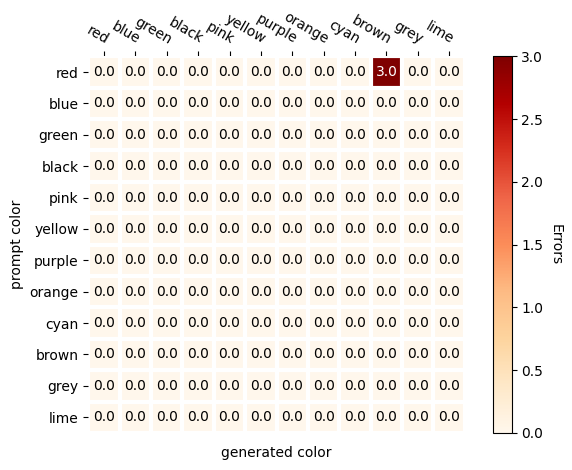

In [8]:
print(f"Acc = {em/count:.2f} ({em}/{count})")
fig, ax = plt.subplots()
im, cbar = heatmap(confusion_matrix, 
                   "prompt color", "generated color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

### Evaluate & Visualize samples generated during inference

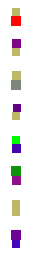

In [4]:
ckpt_handle = "1105_154436"
split = "test"
infr_handle = "epoch199_1106_091719"
samples_dir = f"../scripts/diffuser/output/{ckpt_handle}/infr/{split}_sentences/{infr_handle}/samples"
f = random.choice(os.listdir(samples_dir))
with open(os.path.join(samples_dir, f.replace(".png", ".txt")), "r") as txt:
    input_texts = [l.strip() for l in txt.readlines()]
im = Image.open(os.path.join(samples_dir, f.replace(".txt", ".png")))
im

In [5]:
epochs_for_eval = [199]
ckpt_handle = "1105_154436"

(em, cm, count,
 cfsmtrx_em_coarse,
 cfsmtrx_cm_coarse,
 cfsmtrx_em_fine,
 cfsmtrx_cm_fine,
) = get_em_cm_and_confusion_matrices(ckpt_handle, epochs_for_eval, 'mse')


100%|██████████| 572/572 [02:05<00:00,  4.55it/s]


Acc = 0.22 (538/2448)
colors_match = 0.41 (1008/2448)


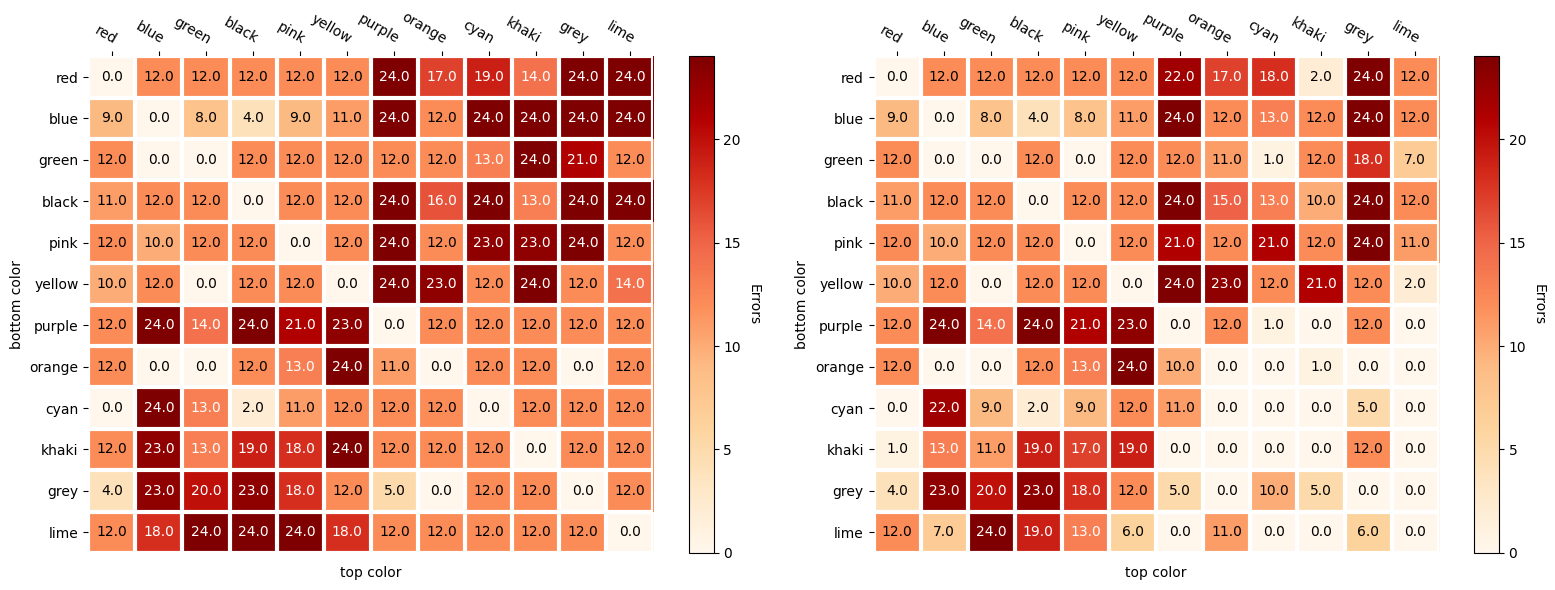

In [6]:
print(f"Acc = {em/count:.2f} ({em}/{count})")
print(f"colors_match = {cm/count:.2f} ({cm}/{count})")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
im, cbar = heatmap(cfsmtrx_em_coarse, 
                   "bottom color", "top color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")


ax = fig.add_subplot(122)
im, cbar = heatmap(cfsmtrx_cm_coarse, 
                   "bottom color", "top color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

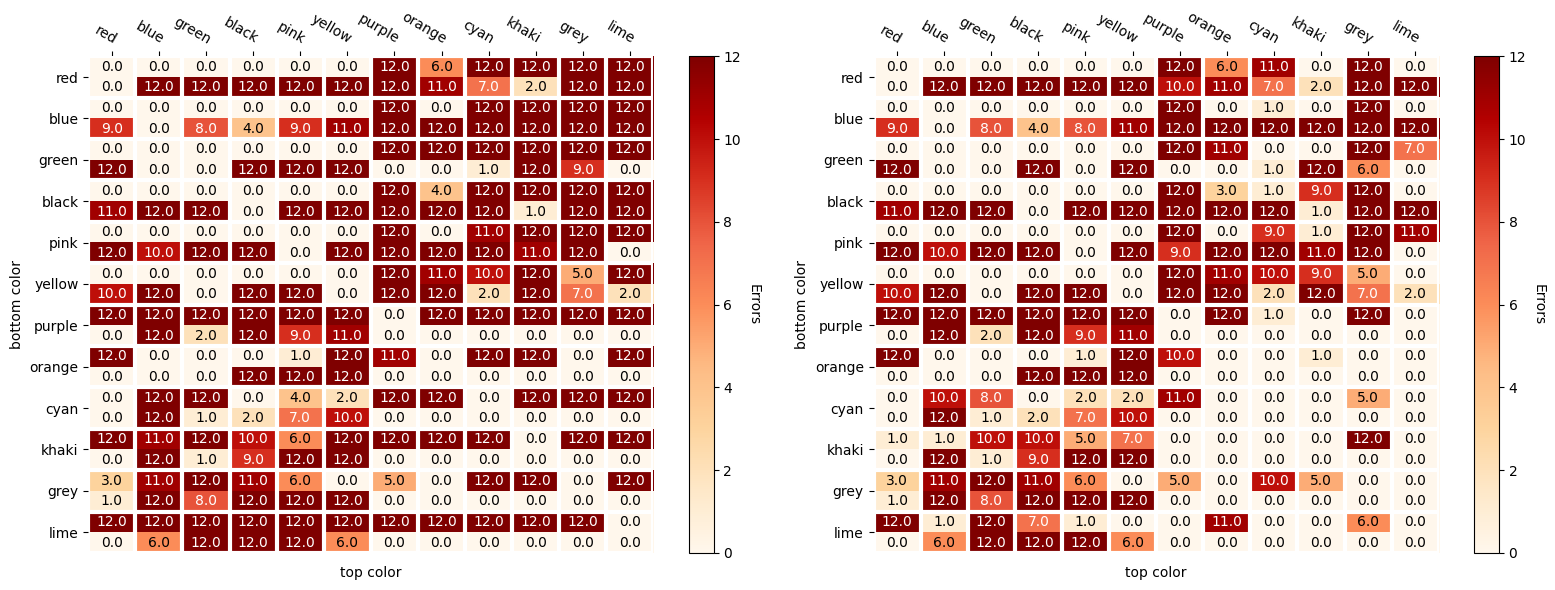

In [7]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
im, cbar = heatmap(cfsmtrx_em_fine, 
                   "bottom color", "top color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   y_ticks=[i*2+0.5 for i in range(cfsmtrx_em_fine.shape[0]//2)],
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")


ax = fig.add_subplot(122)
im, cbar = heatmap(cfsmtrx_cm_fine, 
                   "bottom color", "top color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   y_ticks=[i*2+0.5 for i in range(cfsmtrx_cm_fine.shape[0]//2)],
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

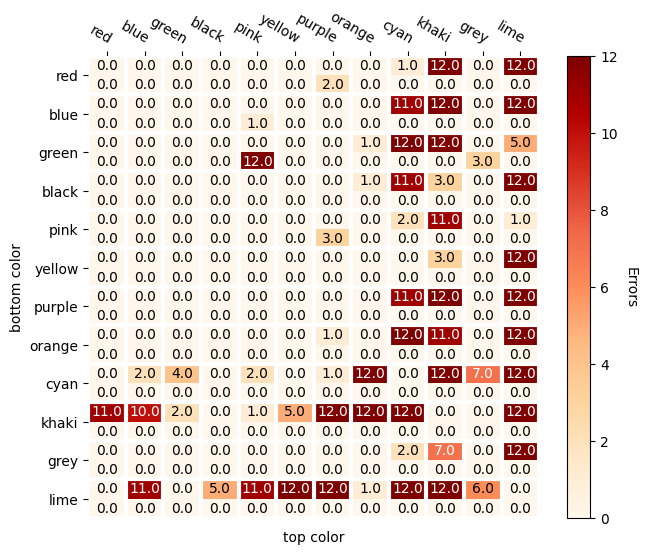

In [8]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
im, cbar = heatmap(cfsmtrx_em_fine-cfsmtrx_cm_fine, 
                   "bottom color", "top color",
                   list(COLORS.keys()), list(COLORS.keys()), 
                   y_ticks=[i*2+0.5 for i in range(cfsmtrx_cm_fine.shape[0]//2)],
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
texts = annotate_heatmap(im, valfmt="{x:.1f}")
plt.show()

### Sanity check: image normalization and denormalization


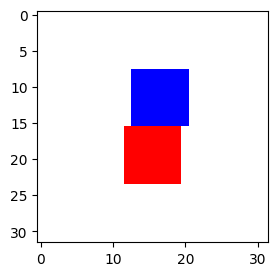

In [13]:
from torchvision import transforms
from PIL import Image
imagepreprocess = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
image = Image.open("../data/matplotlib/colored_2sq/images/0000006.png")#.convert("RGB")
image = imagepreprocess(image)
plt.figure(figsize=(3,3))
plt.imshow(image.permute(1,2,0).numpy() * 0.5 + 0.5)


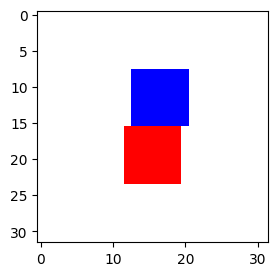

In [12]:
image = (image / 2 + 0.5).clamp(0, 1) # (image / 2 + 0.5).
plt.figure(figsize=(3,3))
plt.imshow(image.permute(1,2,0).numpy())

In [35]:
import re

In [39]:
re.findall(r'epoch(\d+)', "12321_2335_epoch49")

['49']